# Deep Learning Models

A collection of deep learning models implemented on Pytorch for training purposes.

Author: Lucas Martinuzzo Batista<br>
GitHub: https://github.com/LucasMartinuzzo/Deep-Learning-Models

## Multilayer Perceptron with Dropout

Implementation of a MLP with 2 hidden layers using a dropout of 50%.

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_blobs
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import time

In [2]:
device = "cpu"
if torch.cuda.is_available():
    print("Cuda is Available!")
    device = torch.device("cuda")
    torch.backends.cudnn.deterministic = True

Cuda is Available!


### Dataset

In [3]:
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1024

In [4]:
#transforms.ToTensor() normalizes the image from 0 - 255 to 0 - 1.
train_dataset = datasets.FashionMNIST(root="../../data/",
                                      train=True,
                                      download=True,
                                      transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root="../../data/",
                                      train=False,
                                      download=False,
                                      transform=transforms.ToTensor())

In [5]:
train_size = len(train_dataset)
test_size = len(test_dataset)

In [6]:
train_loader = DataLoader(train_dataset,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=TEST_BATCH_SIZE)

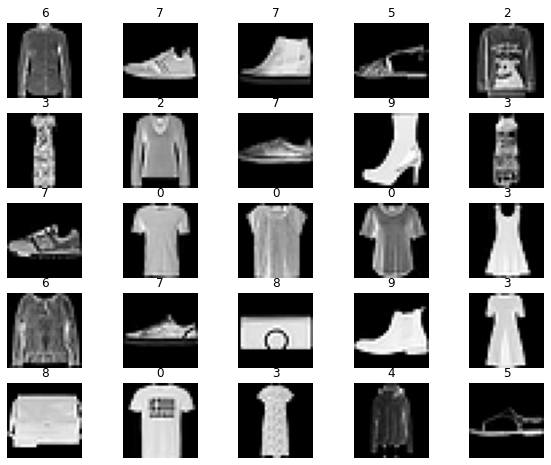

In [7]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Network

In [8]:
NUM_FEATURES = 28*28
DATASET_SIZE = len(test_dataset)
NUM_HIDDEN_1 = 64
NUM_HIDDEN_2 = 128
NUM_CLASSES = 10
RANDOM_SEED = 42
DROPOUT_PROB = 0.5

In [9]:
torch.manual_seed(RANDOM_SEED)

In [10]:
class MultilayerPerceptron(nn.Module):
  #Constructor
    def __init__(self,num_features,num_classes,num_hidden_1,num_hidden_2):
        super(MultilayerPerceptron,self).__init__()
        self.hidden1 = nn.Linear(num_features,num_hidden_1)
        self.hidden2 = nn.Linear(num_hidden_1,num_hidden_2)
        self.linear_out = nn.Linear(num_hidden_2,num_classes)
        
    
    def forward(self,x):
        out = self.hidden1(x)
        out = torch.relu(out)
        out = nn.functional.dropout(out,p=DROPOUT_PROB)
        
        out = self.hidden2(out)
        out = torch.relu(out)
        out = nn.functional.dropout(out,p=DROPOUT_PROB)
        
        out = self.linear_out(out)
        logits = torch.relu(out)
        probs = nn.functional.log_softmax(logits,dim=1)
        
        return logits, probs

In [11]:
model = MultilayerPerceptron(NUM_FEATURES,NUM_CLASSES,NUM_HIDDEN_1,NUM_HIDDEN_2)

In [12]:
model.to(device)

MultilayerPerceptron(
  (hidden1): Linear(in_features=784, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=128, bias=True)
  (linear_out): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.05)
loss_criterion = nn.CrossEntropyLoss()

In [14]:
def train(model,optimizer,loss_function,train_loader,test_loader,epochs,train_size,test_size):
    LOSSES = []
    ACCURACIES = []
    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        accumulated_loss = 0
        correct = 0
        for x, y in train_loader:
            x = x.view(-1,NUM_FEATURES).to(device)
            y = y.to(device)
            optimizer.zero_grad()
            logits,probs = model(x)
            loss = loss_function(logits,y)
            loss.backward()
            optimizer.step()
            accumulated_loss += loss.item()
            y_hat = probs.argmax(dim=1)
            correct += (y_hat  == y).sum().item()
        LOSSES.append(accumulated_loss)
        train_accuracy = correct/train_size
        model.eval()
        correct = 0
        for x_test,y_test in test_loader:
            x_test = x_test.view(-1,NUM_FEATURES).to(device)
            y_test = y_test.to(device)
            logits,probs = model(x_test)
            y_hat = probs.argmax(dim=1)
            correct += (y_hat  == y_test).sum().item()
        test_accuracy = correct/test_size
        print("Epoch {}/{}. Cost: {}. Train Accuracy: {}. Test Accuracy: {}".format(
                epoch+1,epochs,accumulated_loss,train_accuracy,test_accuracy))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        ACCURACIES.append(test_accuracy)
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return LOSSES,ACCURACIES

In [15]:
LOSS, ACC = train(model,optimizer,loss_criterion,train_loader,test_loader,
                  epochs=20,train_size=train_size,test_size=test_size)

Epoch 1/20. Cost: 1177.50631326437. Train Accuracy: 0.5343666666666667. Test Accuracy: 0.6871
Time elapsed: 0.15 min
Epoch 2/20. Cost: 682.2556107640266. Train Accuracy: 0.7360833333333333. Test Accuracy: 0.7492
Time elapsed: 0.31 min
Epoch 3/20. Cost: 595.983133494854. Train Accuracy: 0.7733166666666667. Test Accuracy: 0.7736
Time elapsed: 0.47 min
Epoch 4/20. Cost: 555.3546867370605. Train Accuracy: 0.7889333333333334. Test Accuracy: 0.7809
Time elapsed: 0.62 min
Epoch 5/20. Cost: 524.7412259727716. Train Accuracy: 0.80055. Test Accuracy: 0.7935
Time elapsed: 0.78 min
Epoch 6/20. Cost: 511.33560290932655. Train Accuracy: 0.80585. Test Accuracy: 0.7861
Time elapsed: 0.94 min
Epoch 7/20. Cost: 495.6147143095732. Train Accuracy: 0.8131833333333334. Test Accuracy: 0.7977
Time elapsed: 1.10 min
Epoch 8/20. Cost: 485.95368276536465. Train Accuracy: 0.81515. Test Accuracy: 0.8104
Time elapsed: 1.25 min
Epoch 9/20. Cost: 475.126179382205. Train Accuracy: 0.8209166666666666. Test Accuracy: 0.

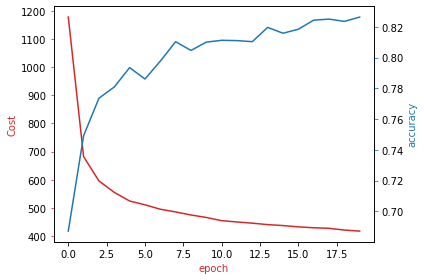

In [16]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(LOSS, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( ACC, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()